Structured Learning:
=====================
In this exercise we will implement a structured learning system for
foreground background segmentation.
We will learn the weights of a CRF Potts model.


The first step is to  import all needed modules

In [10]:
# misc
import numpy
import sys

# visualization
import matplotlib.pyplot as plt
import pylab

# features
import skimage.filters
import skimage.feature

# discrete graphical model package
from dgm.models import *
from dgm.solvers import *
from dgm.value_tables import *
# misc. tools
from tools import make_toy_dataset, norm01
import matplotlib.pyplot as plt

from tools import make_toy_dataset, norm01

The Dataset
===============

Here we use a toy dataset where we have white squares on black background
with some noise.
The noise level is given by the variable ``noise``.


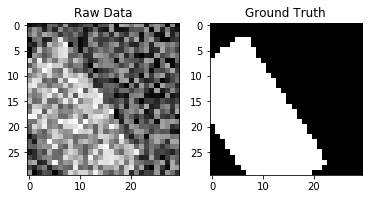

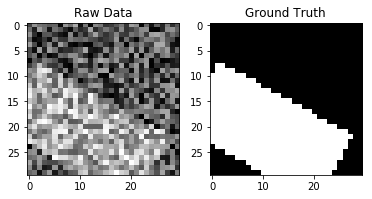

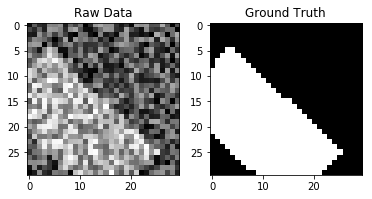

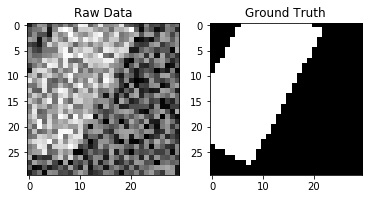

In [6]:
noise = 2.0
shape = (30,30)

x_train, y_train =  make_toy_dataset(shape=shape, n_images=5, noise=noise)
x_test , y_test  =  make_toy_dataset(shape=shape, n_images=5, noise=noise)

# show a bit from the dataset
for x in range(4):
    f= pylab.figure()
    ax1 = f.add_subplot(1,2,1)
    pylab.imshow(x_train[x],cmap='gray')
    ax1.set_title('Raw Data')

    ax2 = f.add_subplot(1,2,2)
    pylab.imshow(y_train[x],cmap='gray')
    ax2.set_title('Ground Truth')
    plt.show()

The Unary  Features (5Pt):
==============

Here you need to implement a function which should return 
pixel wise unary features.
You can use features like gaussian smooting with differnet 
sigmas.
About 5 features should be enough.

The features should be normalized to be in [0,1]



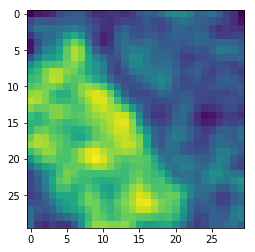

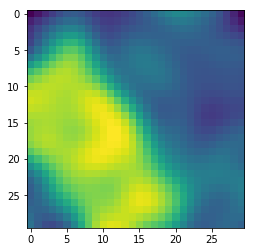

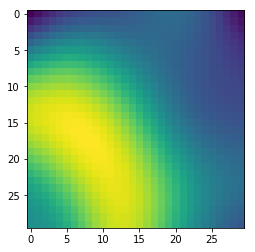

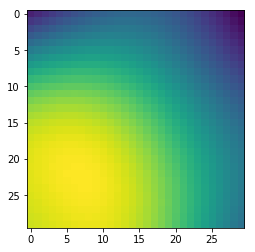

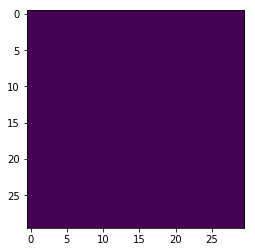

In [9]:
from skimage.morphology import disk

def get_unary_features(raw):
    features = []
    
    # Normalize picuteres
    raw -= raw.min()
    raw /= raw.max()
    
    features.append(skimage.filters.gaussian(raw, sigma=1)[:,:,None])
    features.append(skimage.filters.gaussian(raw, sigma=2)[:,:,None])
    features.append(skimage.filters.gaussian(raw, sigma=5)[:,:,None])
    features.append(skimage.filters.gaussian(raw, sigma=10)[:,:,None])
    
    # Constant feature, keep, because of linearity
    features.append(numpy.ones(raw.shape)[:,:,None])
    return  numpy.concatenate(features, axis=2)
    


# visualize the features for a raw image
unary_features = get_unary_features(x_train[0])
n_unary_features = unary_features.shape[2]
for i in range(unary_features.shape[2]):
    pylab.imshow(unary_features[:,:,i])
    pylab.show()

The Potts Features (5 P):
==========
Here youn need to implement a function returing pixel
wise features which are used within the potts term.
The features should be something like edge detectors.

e^{-1.0 |edge_strength|}$ should work well.

You can compute edge filters on on different sigmas by presmoothing the 
raw data with a gaussian.
About five features should be enough.

The features should be normalized to be in [0,1]


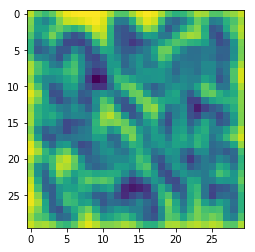

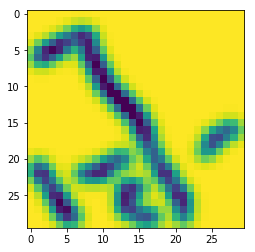

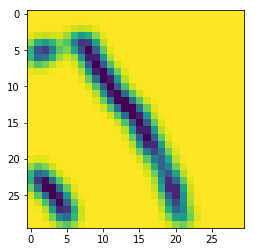

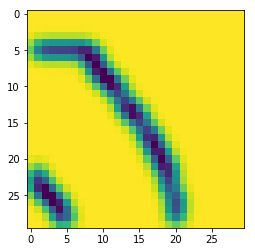

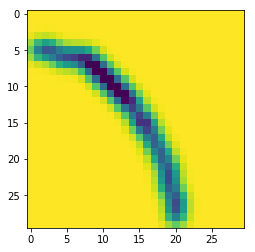

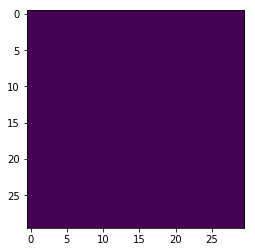

In [23]:
def get_potts_features(raw):
    features = []

    for sigma in (1, 2, 3, 4, 5):
        edges = skimage.feature.canny(raw, sigma=sigma)
        features.append(
            skimage.filters.gaussian(
                numpy.exp(-1.0 * numpy.abs(edges))
            )[:,:,None]
        )
    
    # a constant feature is needed 
    features.append(numpy.ones(raw.shape)[:,:,None])
    return  numpy.concatenate(features, axis=2)


# visualize the features for a raw image
potts_features = get_potts_features(x_train[0])
n_potts_features = potts_features.shape[2]
for i in range(potts_features.shape[2]):
    pylab.imshow(potts_features[:,:,i])
    pylab.show()

Loss Function:
==========

In  this example we will use a very simple ``Hamming Loss``.

In [24]:
class HammingLoss(object):
    def __init__(self, y_true):
        self.y_true = y_true.copy()
    
    def __call__(self, y_pred):
        """total loss"""
        return numpy.sum(self.y_true!=y_pred)
    

Function to set up the weighted Model:
======================
This function will set up the weighted graphical model
and also the loss augmented


Model: $$\textbf{argmin}_{y} \quad w \cdot \phi(x,y) $$
Loss Augmented Model: $$\textbf{argmin}_{y} \quad w \cdot \phi(x,y)  - \Delta(\hat{y},y)$$

In [25]:
def build_model(raw_data, gt_image, weights): 
    shape = raw_data.shape
    n_var = shape[0] * shape[1]
    n_labels = 2 
    variable_space = numpy.ones(n_var)*n_labels


    # lets compute some filters for the uanry features
    unary_features = get_unary_features(raw_data)
    
    # lets compute some filters for the potts features
    potts_features = get_potts_features(raw_data)

    n_weights =potts_features.shape[2] + unary_features.shape[2]
    
    #print("n_weights",n_weights)
    assert n_weights == len(weights)


    # both graphical models
    gm = WeightedDiscreteGraphicalModel(variable_space=variable_space, weights=weights)
    loss_augmented_gm = WeightedDiscreteGraphicalModel(variable_space=variable_space, weights=weights)
    
    # convert coordinates to scalar
    def vi(x0,x1):  # vi = variable index
        return x1 + x0*shape[1]


    # weight ids for the unaries
    # (just plain numbers to remeber which weights
    # are associated with the unary features)
    weight_ids = numpy.arange(unary_features.shape[2])
    for x0 in range(shape[0]):
        for x1 in range(shape[1]):

            pixel_val = raw_data[x0, x1]
            gt_label = gt_image[x0, x1]
            features = unary_features[x0, x1, :]

            unary_function = WeightedTwoClassUnary(features=features, weight_ids=weight_ids, 
                                                 weights=weights)

            if gt_label == 0:
                loss = numpy.array([0,1])
            else:
                loss = numpy.array([1,0])

            loss_augmented_unary_function = WeightedTwoClassUnary(features=features, weight_ids=weight_ids, 
                                                   weights=weights, const_terms=-1.0*loss)

            variables = vi(x0,x1)
            gm.add_factor(variables=variables, value_table=unary_function)
            loss_augmented_gm.add_factor(variables=variables, value_table=loss_augmented_unary_function)

    # add pairwise factors
    # the weight id's for the pairwise factors
        
    # average over 2 coordinates to extract
    # extract feature vectors for potts functins
    def get_potts_feature_vec(coord_a, coord_b):
        
        fa = potts_features[coord_a[0],coord_a[1],:]
        fb = potts_features[coord_b[0],coord_b[1],:]
        return (fa+fb)/2.0

    # weight ids for the potts functions
    # (just plain numbers to remeber which weights
    # are associated with the potts features)
    weight_ids = numpy.arange(potts_features.shape[2]) + unary_features.shape[2]

    for x0 in range(shape[0]):
        for x1 in range(shape[1]):

            # horizontal edge
            if x0 + 1 < shape[0]:
                variables = [vi(x0,x1),vi(x0+1,x1)]
                features = get_potts_feature_vec((x0,x1), (x0+1,x1))
                # the weighted potts function
                potts_function = WeightedPottsFunction(shape=[2,2],
                                                       features=features, 
                                                       weight_ids=weight_ids, 
                                                       weights=weights)
                # add factors to both models
                gm.add_factor(variables=variables, value_table=potts_function)
                loss_augmented_gm.add_factor(variables=variables, value_table=potts_function)

            # vertical edge
            if x1 + 1 < shape[1]:
                variables = [vi(x0,x1),vi(x0, x1+1)]
                features = get_potts_feature_vec((x0,x1), (x0,x1+1))
                # the weighted potts function
                potts_function = WeightedPottsFunction(shape=[2,2],
                                                       features=features, 
                                                       weight_ids=weight_ids,
                                                       weights=weights)
                # add factors to both models
                gm.add_factor(variables=variables, value_table=potts_function)
                loss_augmented_gm.add_factor(variables=variables, value_table=potts_function)
        
    # gm, loss augmented and the loss
    return gm,loss_augmented_gm, HammingLoss(gt_image.ravel())

Build the weighted models:
===============

In [27]:
#
n_weights = n_unary_features + n_potts_features
weights = numpy.zeros(n_weights)

 # build the graphical models
models_train  = [build_model(x,y, weights) for x,y in zip(x_train, y_train)]
models_test   = [build_model(x,y, weights) for x,y in zip(x_test, y_test)]


# very simple helper class to combine things
class Dataset(object):
    def __init__(self, models_train, models_test, weights):
        self.models_train = models_train
        self.models_test = models_test
        self.weights = weights
dset = Dataset(models_train, models_test, weights)

Subgradient SSVM
=========================

Instead of a cutting plane approach, we use a subgradient decent to
find the optimal weights

[Learn more about subgradient ssvm](https://www.google.de/url?sa=t&rct=j&q=&esrc=s&source=web&cd=3&cad=rja&uact=8&ved=0ahUKEwjkwJrWuPvTAhWLbVAKHWx-DQoQFgg3MAI&url=http%3A%2F%2Fwww.nowozin.net%2Fsebastian%2Fcvpr2011tutorial%2Fslides%2Ftalk-ssvm.pdf&usg=AFQjCNH6ZetauyPusXpNBWxdmZshHujgmw&sig2=q1tJ-0DgX9WuGuDIK8-eJw)

In [68]:
def subgradient_ssvm(dataset, n_iter=20, learning_rate=1.0, c=0.5, lower_bounds=None, upper_bounds=None, convergence=0.001, algorithm=GraphCut):
    
    weights = dataset.weights
    n = len(dataset.models_train)
    
    if lower_bounds is None:
        lower_bounds = numpy.ones(len(weights))*-1.0*float('inf')

    if upper_bounds is None:
        upper_bounds = numpy.ones(len(weights))*float('inf')
    
    do_opt = True
    for iteration in range(n_iter): 

        effective_learning_rate = learning_rate*float(learning_rate)/(1.0+iteration)
        
        # compute gradient
        diff = numpy.zeros(weights.shape)
        for gm, gm_loss_augmented, loss_function in dataset.models_train:

            # update the weights to the current weight vector
            gm.change_weights(weights)
            gm_loss_augmented.change_weights(weights)

            # the gt vector
            y_true = loss_function.y_true



            # optimize loss augmented /
            # find most violated constraint
            graphcut = algorithm(model=gm_loss_augmented)
            y_hat = graphcut.optimize()

            # compute joint feature vector
            phi_y_hat  = gm.phi(y_hat)
            phi_y_true = gm.phi(y_true)

            diff +=  phi_y_true - phi_y_hat
    
        

        new_weights = weights - effective_learning_rate*(c/n)*diff

        # project new weights 
        where_to_large = numpy.where(new_weights>upper_bounds)
        new_weights[where_to_large]  = upper_bounds[where_to_large]
        where_to_small = numpy.where(new_weights<lower_bounds)
        new_weights[where_to_small]  = lower_bounds[where_to_small]


        delta = numpy.abs(new_weights-weights).sum()
        if(delta<convergence):
            print("converged")
            break
        print('iter',iteration, 'delta',delta,"  ",numpy.round(new_weights,3))

        weights = new_weights
    

    return weights

Learn The Weights:
==========================

We call use graphcut to find the argmin of the gm and
the loss augmented gm.
Graphcut will find optimal values iff the potts regularizer is 
positive.
To ensure a positive regularizer is learned, we 
can constraint the weights of the potts function to be positive. 


In [29]:

lower_bounds = numpy.ones(len(weights))*(-1.0*float('inf'))

# we want the regularizer 'beta' to be positive
lower_bounds[n_unary_features:n_unary_features+n_potts_features] = 0
    
weights = subgradient_ssvm(dset,c=0.5,learning_rate=1.0, lower_bounds=lower_bounds, n_iter=100)


iter 0 delta 148.301948269    [-32.05  -25.162  -7.94   11.149  72.      0.      0.      0.      0.      0.
   0.   ]
iter 1 delta 315.881335136    [-93.278 -84.535 -62.031 -35.541 -22.5     0.      0.      0.      0.      0.
   0.   ]
iter 2 delta 216.586094929    [-63.143 -53.341 -28.618  -0.698  64.5     0.      0.      0.      0.      0.
   0.   ]
iter 3 delta 15.1156490128    [-61.085 -51.222 -26.47    1.362  68.925   0.4     0.572   0.475   0.363
   0.37    0.125]
iter 4 delta 5.8495989785    [-61.669 -51.795 -27.047   0.812  67.665   0.      0.      0.      0.      0.
   0.   ]
iter 5 delta 0.770754366329    [-61.523 -51.65  -26.91    0.938  67.882   0.      0.      0.      0.      0.
   0.   ]
iter 6 delta 0.131381588897    [-61.531 -51.658 -26.923   0.923  67.796   0.      0.      0.      0.      0.
   0.   ]
iter 7 delta 0.069690615693    [-61.52  -51.647 -26.917   0.926  67.758   0.      0.      0.      0.      0.
   0.   ]
iter 8 delta 0.0619472139493    [-61.511 -51.636 -2

iter 68 delta 0.00938864669911    [-61.249 -51.355 -26.71    1.065  67.321   0.      0.      0.      0.      0.
   0.   ]
iter 69 delta 0.00925452317483    [-61.247 -51.353 -26.708   1.066  67.318   0.      0.      0.      0.      0.
   0.   ]
iter 70 delta 0.00912417777801    [-61.245 -51.351 -26.707   1.067  67.316   0.      0.      0.      0.      0.
   0.   ]
iter 71 delta 0.00899745308665    [-61.244 -51.349 -26.705   1.068  67.313   0.      0.      0.      0.      0.
   0.   ]
iter 72 delta 0.00887420030464    [-61.242 -51.347 -26.704   1.069  67.31    0.      0.      0.      0.      0.
   0.   ]
iter 73 delta 0.00875427867891    [-61.24  -51.345 -26.703   1.07   67.307   0.      0.      0.      0.      0.
   0.   ]
iter 74 delta 0.00863755496318    [-61.238 -51.343 -26.701   1.071  67.305   0.      0.      0.      0.      0.
   0.   ]
iter 75 delta 0.0085239029242    [-61.236 -51.341 -26.7     1.072  67.302   0.      0.      0.      0.      0.
   0.   ]
iter 76 delta 0.008413202

Training Set Performance:
===============

learnedn weights [-61.20162564 -51.30311871 -26.67284331   1.09018464  67.24514042   0.           0.
   0.           0.           0.           0.        ]


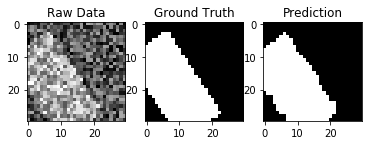

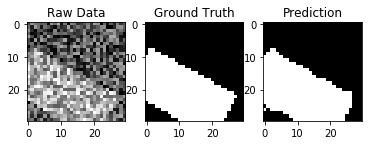

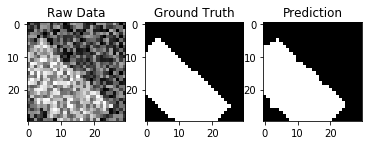

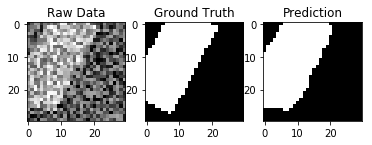

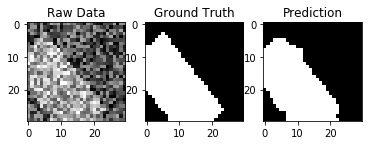

In [30]:
print("learnedn weights",weights)
for i,(gm,_,loss_function) in enumerate(models_train):
    gm.change_weights(weights)
    
    
    graphcut = GraphCut(model=gm)
    y_pred = graphcut.optimize()
    
    prediction_image = y_pred.reshape(shape)
    
    # show a bit from the dataset
   
    f= pylab.figure()
    ax1 = f.add_subplot(1,3,1)
    pylab.imshow(x_train[i],cmap='gray')
    ax1.set_title('Raw Data')
    
    ax2 = f.add_subplot(1,3,2)
    pylab.imshow(y_train[i],cmap='gray')
    ax2.set_title('Ground Truth')
 
    ax3 = f.add_subplot(1,3,3)
    pylab.imshow(prediction_image,cmap='gray')
    ax3.set_title('Prediction')
    
    plt.show()

    
            

Test set performance:
==============

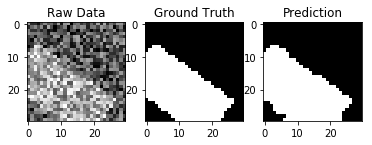

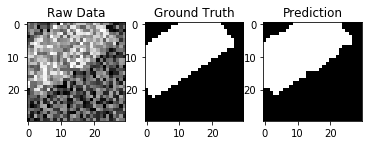

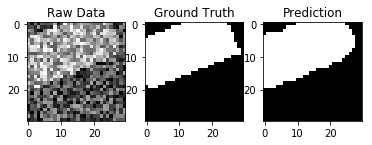

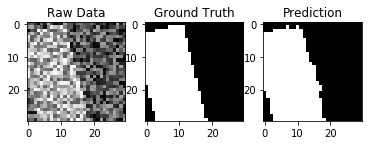

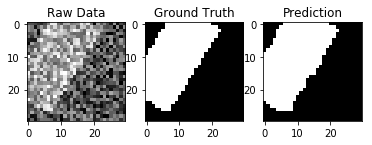

In [31]:
for i,(gm,_,loss_function) in enumerate(models_test):
    gm.change_weights(weights)
    
 
    graphcut = GraphCut(model=gm)
    y_pred = graphcut.optimize()
    
    prediction_image = y_pred.reshape(shape)
    
    # show a bit from the dataset
   
    f= pylab.figure()
    ax1 = f.add_subplot(1,3,1)
    pylab.imshow(x_test[i],cmap='gray')
    ax1.set_title('Raw Data')
    
    ax2 = f.add_subplot(1,3,2)
    pylab.imshow(y_test[i],cmap='gray')
    ax2.set_title('Ground Truth')
 
    ax3 = f.add_subplot(1,3,3)
    pylab.imshow(prediction_image,cmap='gray')
    ax3.set_title('Prediction')
    
    plt.show()


Experiments (5 P):
=============
Compute The test set performance (loss on test test) for different noise values
(1.5, 2.0, 2.5, 3.0, 3.5)  and different regularizers C (0.1 0.5 0.9, 5, 10).

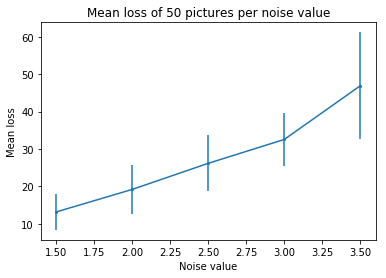

In [70]:
noises = [1.5, 2., 2.5, 3., 3.5]
dataset = numpy.zeros((len(noises), 2))
for j, noise in enumerate(noises):
    x_test , y_test  =  make_toy_dataset(shape=shape, n_images=50, noise=noise)
    models_test   = [build_model(x,y, weights) for x,y in zip(x_test, y_test)]
    losses = []
    for i, (gm, _, loss_function) in enumerate(models_test):
        lf = HammingLoss(y_test[i])
        
        gm.change_weights(weights)
        graphcut = GraphCut(model=gm)
        y_pred = graphcut.optimize()
        prediction_image = y_pred.reshape(shape)
        
        losses.append(lf(prediction_image))
    dataset[j, 0] = numpy.mean(losses)
    dataset[j, 1] = numpy.std(losses)
plt.cla()
plt.errorbar(noises, dataset[:, 0], marker='o', markersize=2, yerr=dataset[:, 1])
plt.title('Mean loss of 50 pictures per noise value')
plt.xlabel('Noise value')
plt.ylabel('Mean loss')
plt.show()

In [72]:
Cs = [.1, .5, .9, 5, 10]
dataset = numpy.zeros((len(Cs), 2))
for j, C in enumerate(Cs):
    weights = subgradient_ssvm(dset,c=C,learning_rate=1.0, lower_bounds=lower_bounds, n_iter=100)
    
    x_test , y_test  =  make_toy_dataset(shape=shape, n_images=50, noise=noise)
    models_test   = [build_model(x,y, weights) for x,y in zip(x_test, y_test)]
    losses = []
    for i, (gm, _, loss_function) in enumerate(models_test):
        lf = HammingLoss(y_test[i])
        
        gm.change_weights(weights)
        graphcut = GraphCut(model=gm)
        y_pred = graphcut.optimize()
        prediction_image = y_pred.reshape(shape)
        
        losses.append(lf(prediction_image))
    dataset[j, 0] = numpy.mean(losses)
    dataset[j, 1] = numpy.std(losses)

iter 0 delta 29.6603896538    [ -6.41   -5.032  -1.588   2.23   14.4     0.      0.      0.      0.      0.
   0.   ]
iter 1 delta 63.1762670272    [-18.656 -16.907 -12.406  -7.108  -4.5     0.      0.      0.      0.      0.
   0.   ]
iter 2 delta 43.3172189859    [-12.629 -10.668  -5.724  -0.14   12.9     0.      0.      0.      0.      0.
   0.   ]
iter 3 delta 10.9121293799    [-11.773  -9.799  -4.833   0.734  14.86    0.769   0.977   0.975   0.939
   0.937   0.865]
iter 4 delta 16.8335039699    [-14.236 -12.168  -6.992  -1.163  10.936   0.164   0.375   0.346   0.277
   0.242   0.037]
iter 5 delta 23.0058643946    [-11.232  -9.059  -3.663   2.307  19.589   0.      0.      0.      0.      0.
   0.   ]
iter 6 delta 18.0503620078    [-14.731 -12.452  -6.754  -0.361  14.189   0.      0.      0.      0.      0.
   0.   ]
iter 7 delta 8.52923815112    [-13.988 -11.7    -5.979   0.41   15.964   0.504   0.672   0.675   0.653
   0.641   0.57 ]
iter 8 delta 1.50564230749    [-14.105 -11.808 

iter 60 delta 0.00275480160479    [-14.235 -11.874  -6.121   0.289  15.525   0.05    0.035   0.      0.      0.
   0.   ]
iter 61 delta 0.00329139513302    [-14.236 -11.875  -6.121   0.289  15.524   0.051   0.036   0.      0.      0.
   0.   ]
iter 62 delta 0.00335627886686    [-14.236 -11.874  -6.12    0.29   15.524   0.051   0.035   0.      0.      0.
   0.   ]
iter 63 delta 0.0026746533547    [-14.236 -11.874  -6.12    0.29   15.524   0.052   0.034   0.      0.      0.
   0.   ]
iter 64 delta 0.00258527535219    [-14.237 -11.874  -6.119   0.29   15.524   0.052   0.033   0.      0.      0.
   0.   ]
iter 65 delta 0.00309191664011    [-14.237 -11.874  -6.119   0.291  15.523   0.053   0.034   0.      0.      0.
   0.   ]
iter 66 delta 0.00315583645964    [-14.237 -11.874  -6.119   0.291  15.523   0.053   0.033   0.      0.      0.
   0.   ]
iter 67 delta 0.00251732080443    [-14.238 -11.873  -6.119   0.292  15.523   0.054   0.032   0.      0.      0.
   0.   ]
iter 68 delta 0.002435404

iter 28 delta 0.0223385042151    [-61.359 -51.474 -26.795   1.008  67.499   0.      0.      0.      0.      0.
   0.   ]
iter 29 delta 0.0215938874079    [-61.355 -51.469 -26.791   1.011  67.492   0.      0.      0.      0.      0.
   0.   ]
iter 30 delta 0.0208973103948    [-61.35  -51.465 -26.788   1.013  67.486   0.      0.      0.      0.      0.
   0.   ]
iter 31 delta 0.0202442694449    [-61.346 -51.46  -26.785   1.015  67.48    0.      0.      0.      0.      0.
   0.   ]
iter 32 delta 0.0196308067345    [-61.342 -51.456 -26.782   1.017  67.474   0.      0.      0.      0.      0.
   0.   ]
iter 33 delta 0.0163977919278    [-61.34  -51.453 -26.78    1.018  67.465   0.      0.      0.      0.      0.
   0.   ]
iter 34 delta 0.0211074843506    [-61.335 -51.448 -26.776   1.021  67.462   0.      0.      0.      0.      0.
   0.   ]
iter 35 delta 0.0154868034873    [-61.332 -51.445 -26.774   1.022  67.454   0.      0.      0.      0.      0.
   0.   ]
iter 36 delta 0.0175085573578   

iter 96 delta 0.00667852187875    [-61.206 -51.307 -26.676   1.088  67.251   0.      0.      0.      0.      0.
   0.   ]
iter 97 delta 0.00661037369631    [-61.204 -51.306 -26.675   1.089  67.249   0.      0.      0.      0.      0.
   0.   ]
iter 98 delta 0.00654360224483    [-61.203 -51.305 -26.674   1.089  67.247   0.      0.      0.      0.      0.
   0.   ]
iter 99 delta 0.00647816622238    [-61.202 -51.303 -26.673   1.09   67.245   0.      0.      0.      0.      0.
   0.   ]
iter 0 delta 266.943506884    [ -57.691  -45.292  -14.293   20.068  129.6      0.       0.       0.       0.
    0.       0.   ]
iter 1 delta 568.586403245    [-167.9   -152.163 -111.656  -63.974  -40.5      0.       0.       0.       0.
    0.       0.   ]
iter 2 delta 389.854970873    [-113.657  -96.013  -51.512   -1.257  116.1      0.       0.       0.       0.
    0.       0.   ]
iter 3 delta 24.6526479912    [-110.105  -92.357  -47.812    2.292  123.705    0.495    0.739    0.577
    0.388    0.392    

iter 59 delta 0.0201320607612    [-110.19   -92.449  -48.173    1.819  121.116    0.       0.       0.       0.
    0.       0.   ]
iter 60 delta 0.0198020269783    [-110.185  -92.444  -48.17     1.821  121.11     0.       0.       0.       0.
    0.       0.   ]
iter 61 delta 0.0194826394463    [-110.181  -92.439  -48.167    1.823  121.104    0.       0.       0.       0.
    0.       0.   ]
iter 62 delta 0.0164707138178    [-110.177  -92.437  -48.166    1.823  121.096    0.       0.       0.       0.
    0.       0.   ]
iter 63 delta 0.0188738069637    [-110.173  -92.432  -48.163    1.825  121.09     0.       0.       0.       0.
    0.       0.   ]
iter 64 delta 0.0185834407027    [-110.169  -92.428  -48.16     1.827  121.084    0.       0.       0.       0.
    0.       0.   ]
iter 65 delta 0.0183018734193    [-110.164  -92.424  -48.158    1.828  121.079    0.       0.       0.       0.
    0.       0.   ]
iter 66 delta 0.0180287111295    [-110.16   -92.419  -48.155    1.83   121.0

iter 21 delta 0.31189799921    [-613.209 -514.684 -268.137    9.816  675.378    0.       0.       0.       0.
    0.       0.   ]
iter 22 delta 0.298337216636    [-613.14  -514.615 -268.092    9.846  675.291    0.       0.       0.       0.
    0.       0.   ]
iter 23 delta 0.285906499276    [-613.075 -514.55  -268.049    9.874  675.208    0.       0.       0.       0.
    0.       0.   ]
iter 24 delta 0.274470239305    [-613.011 -514.487 -268.008    9.901  675.128    0.       0.       0.       0.
    0.       0.   ]
iter 25 delta 0.263913691639    [-612.951 -514.426 -267.969    9.928  675.051    0.       0.       0.       0.
    0.       0.   ]
iter 26 delta 0.254139110468    [-612.893 -514.367 -267.93     9.953  674.977    0.       0.       0.       0.
    0.       0.   ]
iter 27 delta 0.245062713665    [-612.836 -514.311 -267.894    9.977  674.905    0.       0.       0.       0.
    0.       0.   ]
iter 28 delta 0.236612275263    [-612.782 -514.256 -267.858   10.     674.836    0. 

iter 84 delta 0.080726540972    [-611.105 -512.576 -266.766   10.724  672.708    0.       0.       0.       0.
    0.       0.   ]
iter 85 delta 0.0797878602631    [-611.087 -512.558 -266.754   10.732  672.685    0.       0.       0.       0.
    0.       0.   ]
iter 86 delta 0.0788707584209    [-611.069 -512.54  -266.742   10.74   672.662    0.       0.       0.       0.
    0.       0.   ]
iter 87 delta 0.0779744998026    [-611.051 -512.522 -266.73    10.748  672.639    0.       0.       0.       0.
    0.       0.   ]
iter 88 delta 0.0770983818273    [-611.033 -512.504 -266.719   10.755  672.617    0.       0.       0.       0.
    0.       0.   ]
iter 89 delta 0.0762417331403    [-611.016 -512.486 -266.707   10.763  672.594    0.       0.       0.       0.
    0.       0.   ]
iter 90 delta 0.075403911897    [-610.999 -512.469 -266.696   10.77   672.572    0.       0.       0.       0.
    0.       0.   ]
iter 91 delta 0.074584304159    [-610.981 -512.452 -266.685   10.778  672.551 

iter 43 delta 0.31189799921    [-1224.257 -1027.176  -534.805    20.641  1347.947     0.        0.        0.
     0.        0.        0.   ]
iter 44 delta 0.304966932561    [-1224.187 -1027.106  -534.759    20.672  1347.858     0.        0.        0.
     0.        0.        0.   ]
iter 45 delta 0.298337216636    [-1224.118 -1027.037  -534.714    20.701  1347.771     0.        0.        0.
     0.        0.        0.   ]
iter 46 delta 0.291989616282    [-1224.051 -1026.97   -534.671    20.73   1347.686     0.        0.        0.
     0.        0.        0.   ]
iter 47 delta 0.285906499276    [-1223.986 -1026.904  -534.628    20.758  1347.603     0.        0.        0.
     0.        0.        0.   ]
iter 48 delta 0.28007167276    [-1223.921 -1026.84   -534.586    20.786  1347.521     0.        0.        0.
     0.        0.        0.   ]
iter 49 delta 0.274470239305    [-1223.858 -1026.777  -534.545    20.813  1347.441     0.        0.        0.
     0.        0.        0.   ]
iter 50 

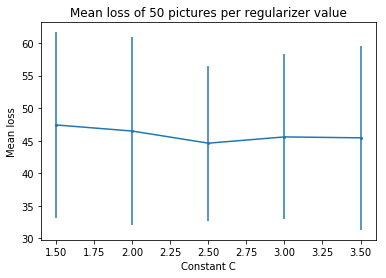

In [73]:
plt.cla()
plt.errorbar(noises, dataset[:, 0], marker='o', markersize=2, yerr=dataset[:, 1])
plt.title('Mean loss of 50 pictures per regularizer value')
plt.xlabel('Constant C')
plt.ylabel('Mean loss')
plt.show()

Experiments (5 P):
=============
Replace GraphCut with IteratedConditionalModes (ICM) to see if optimality is important.


iter 0 delta 148.301948269    [-32.05  -25.162  -7.94   11.149  72.      0.      0.      0.      0.      0.
   0.   ]
iter 1 delta 315.881335136    [-93.278 -84.535 -62.031 -35.541 -22.5     0.      0.      0.      0.      0.
   0.   ]
iter 2 delta 216.586094929    [-63.143 -53.341 -28.618  -0.698  64.5     0.      0.      0.      0.      0.
   0.   ]
iter 3 delta 15.1156490128    [-61.085 -51.222 -26.47    1.362  68.925   0.4     0.572   0.475   0.363
   0.37    0.125]
iter 4 delta 6.02735133396    [-61.701 -51.825 -27.075   0.785  67.605   0.      0.      0.      0.      0.
   0.   ]
iter 5 delta 0.869048533361    [-61.54  -51.663 -26.921   0.927  67.855   0.      0.      0.      0.      0.
   0.   ]
iter 6 delta 0.0723001606803    [-61.535 -51.657 -26.921   0.924  67.798   0.      0.      0.      0.      0.
   0.   ]
iter 7 delta 0.069690615693    [-61.524 -51.645 -26.914   0.927  67.76    0.      0.      0.      0.      0.
   0.   ]
iter 8 delta 0.0619472139493    [-61.515 -51.635 

iter 68 delta 0.00938864669911    [-61.254 -51.354 -26.708   1.067  67.322   0.      0.      0.      0.      0.
   0.   ]
iter 69 delta 0.00925452317483    [-61.252 -51.352 -26.706   1.068  67.319   0.      0.      0.      0.      0.
   0.   ]
iter 70 delta 0.00912417777801    [-61.25  -51.35  -26.705   1.069  67.316   0.      0.      0.      0.      0.
   0.   ]
iter 71 delta 0.00899745308665    [-61.248 -51.348 -26.703   1.069  67.313   0.      0.      0.      0.      0.
   0.   ]
iter 72 delta 0.00887420030464    [-61.246 -51.346 -26.702   1.07   67.311   0.      0.      0.      0.      0.
   0.   ]
iter 73 delta 0.00875427867891    [-61.244 -51.344 -26.701   1.071  67.308   0.      0.      0.      0.      0.
   0.   ]
iter 74 delta 0.00863755496318    [-61.243 -51.342 -26.699   1.072  67.305   0.      0.      0.      0.      0.
   0.   ]
iter 75 delta 0.0085239029242    [-61.241 -51.34  -26.698   1.073  67.303   0.      0.      0.      0.      0.
   0.   ]
iter 76 delta 0.007240583

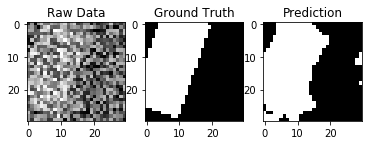

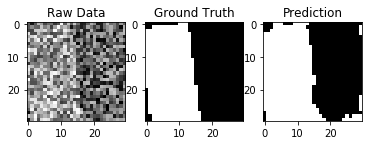

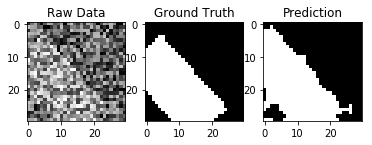

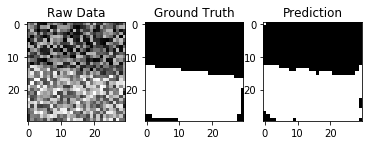

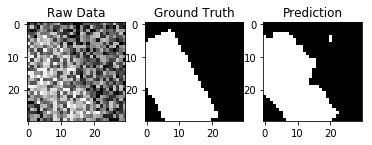

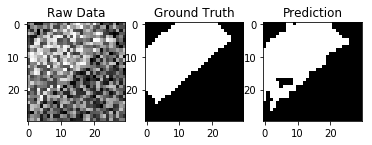

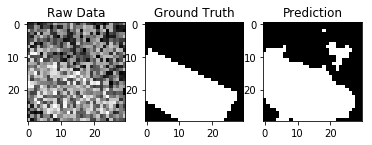

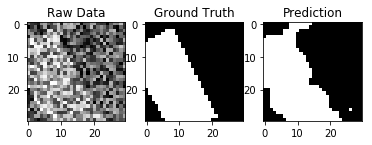

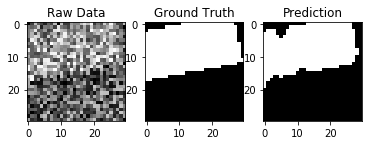

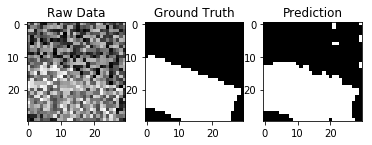

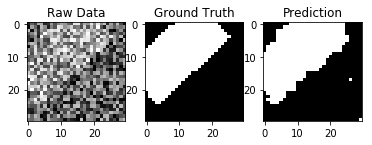

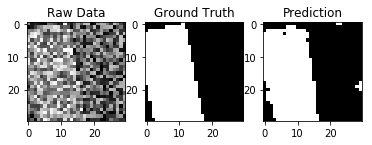

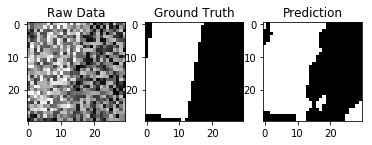

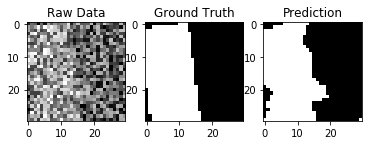

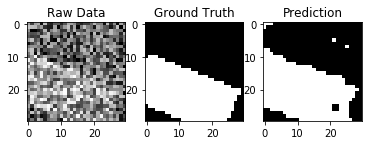

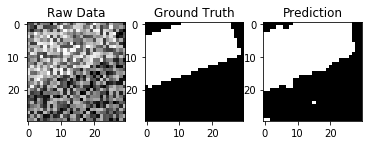

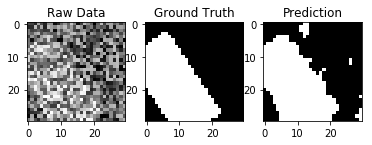

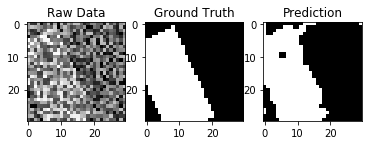

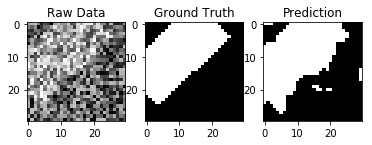

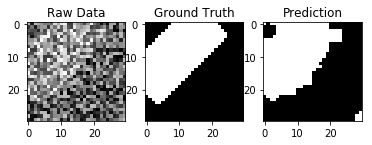

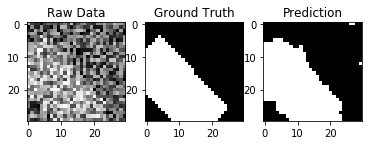

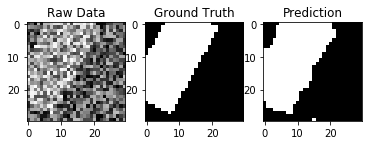

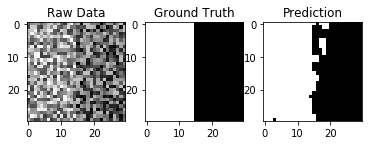

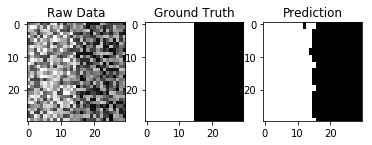

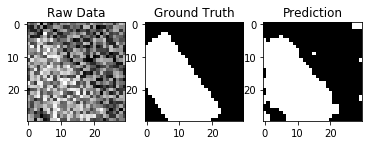

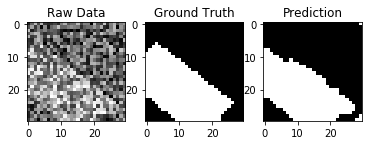

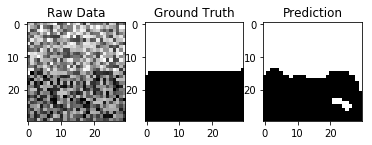

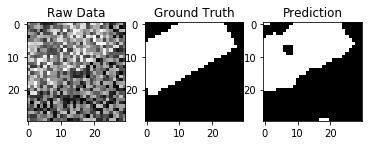

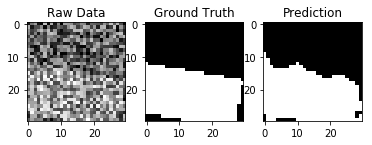

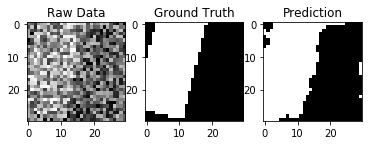

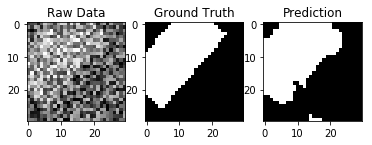

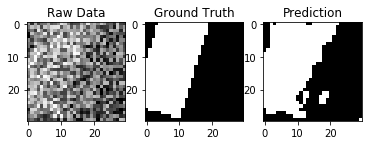

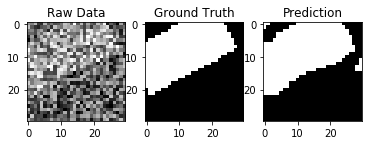

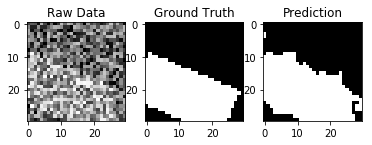

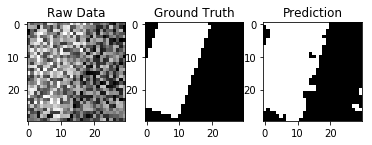

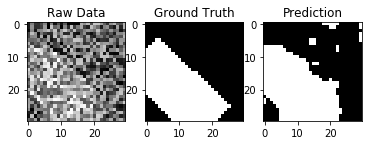

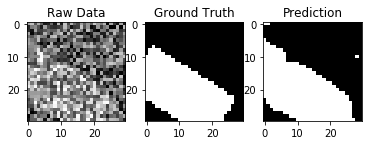

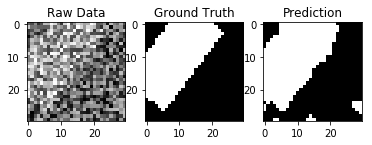

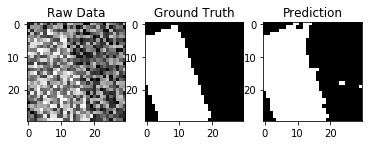

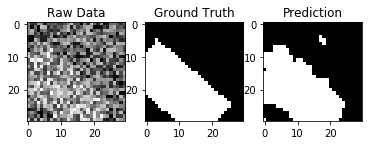

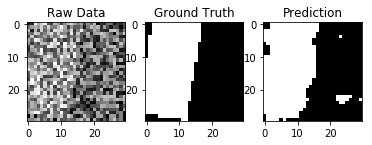

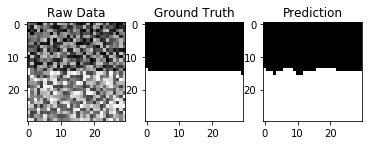

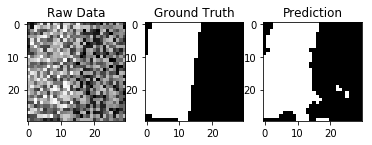

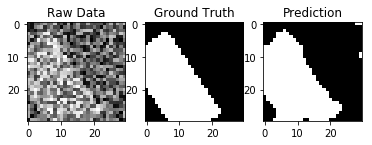

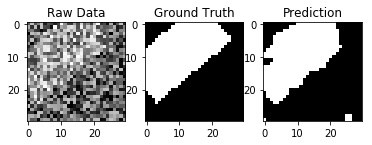

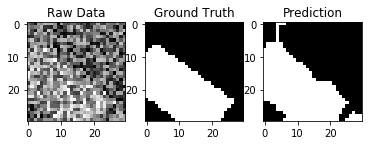

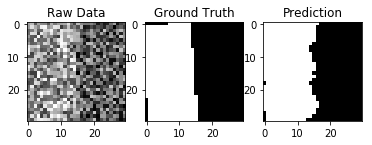

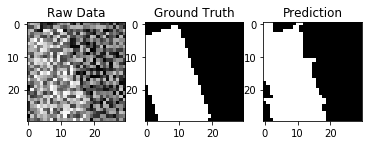

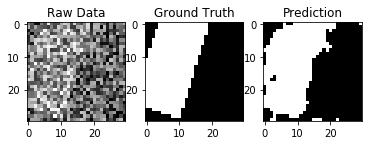

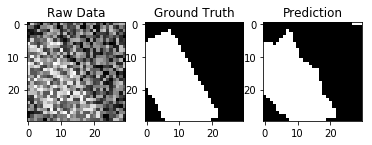

In [74]:
lower_bounds = numpy.ones(len(weights))*(-1.0*float('inf'))

# we want the regularizer 'beta' to be positive
lower_bounds[n_unary_features:n_unary_features+n_potts_features] = 0
    
weights = subgradient_ssvm(dset,c=0.5,learning_rate=1.0, lower_bounds=lower_bounds, n_iter=100,
                           algorithm=IteratedConditionalModes)

for i,(gm,_,loss_function) in enumerate(models_test):
    gm.change_weights(weights)
    
 
    a = IteratedConditionalModes(model=gm)
    y_pred = a.optimize()
    
    prediction_image = y_pred.reshape(shape)
    
    # show a bit from the dataset
   
    f= pylab.figure()
    ax1 = f.add_subplot(1,3,1)
    pylab.imshow(x_test[i],cmap='gray')
    ax1.set_title('Raw Data')
    
    ax2 = f.add_subplot(1,3,2)
    pylab.imshow(y_test[i],cmap='gray')
    ax2.set_title('Ground Truth')
 
    ax3 = f.add_subplot(1,3,3)
    pylab.imshow(prediction_image,cmap='gray')
    ax3.set_title('Prediction')
    
    plt.show()


Yep, Graph cut works way better than ICM.